In [ ]:
import os
import numpy as np
import random
from pathlib import Path
import shutil
from PIL import Image
import json
from tqdm import tqdm
import yaml
from ultralytics import YOLO
import torch

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/Users/regata3010/Library/Application Support/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [12]:
import cv2
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"📍 GPU: {torch.cuda.get_device_name(0)}")
    


PyTorch version: 2.5.1
CUDA available: False


In [8]:
class CelebrityDetectionDataset:
    """Create object detection dataset from CelebA dataset"""
    
    def __init__(self, base_dir="/Users/Deep Learning Core"):
        self.base_dir = Path(base_dir)
        self.celebs_dir = self.base_dir / "celebs"  
        self.data_dir = self.base_dir / "celeba_detection"
        self.your_celeb_id = 10173  
        
        
        self.create_directories()
        
    def create_directories(self):
        """Create YOLO dataset structure"""
        dirs = [
            self.data_dir / "images" / "train",
            self.data_dir / "images" / "val", 
            self.data_dir / "images" / "test",
            self.data_dir / "labels" / "train",
            self.data_dir / "labels" / "val",
            self.data_dir / "labels" / "test",
            self.data_dir / "concatenated_samples"
        ]
        for dir_path in dirs:
            dir_path.mkdir(parents=True, exist_ok=True)
        print(f"✅ Created dataset directories at {self.data_dir}")


dataset = CelebrityDetectionDataset()
print(f"Dataset directory: {dataset.data_dir}")
print(f"Celebs directory: {dataset.celebs_dir}")

✅ Created dataset directories at /Users/Deep Learning Core/celeba_detection
Dataset directory: /Users/Deep Learning Core/celeba_detection
Celebs directory: /Users/Deep Learning Core/celebs


Looking for celebrity 10173 at: /Users/Deep Learning Core/celebs/images_10173
 Loaded 30 images for celebrity 10173
 Found CelebA dataset at: /Users/Deep Learning Core/img_align_celeba
 Found identity file at: /Users/Deep Learning Core/identity_CelebA.txt

Loading 19 additional celebrities from CelebA...


Loading celebrities: 100%|██████████| 19/19 [00:00<00:00, 104.48it/s]


Loaded 19 additional celebrities from CelebA

 Total celebrities loaded: 20
Celebrity 10173: 30 images (YOUR CELEBRITY)
Celebrity 3227: 30 images
Celebrity 2820: 30 images
Celebrity 3782: 30 images
Celebrity 3745: 30 images


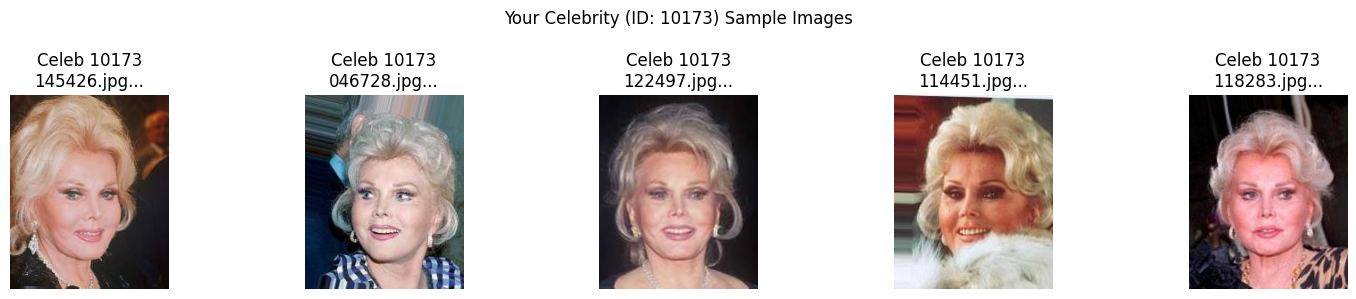

In [ ]:
def load_celebrity_images(dataset):
    """Load images from CelebA dataset structure"""
    celebrity_images = {}
    
    
    celeb_10173_path = dataset.celebs_dir / "images_10173"
    
    print(f"Looking for celebrity 10173 at: {celeb_10173_path}")
    
   
    if celeb_10173_path.exists():
        images_10173 = []
       
        extensions = ['*.jpg', '*.jpeg', '*.png', '*.JPG', '*.JPEG', '*.PNG']
        all_files = []
        for ext in extensions:
            all_files.extend(list(celeb_10173_path.glob(ext)))
        
        for img_file in all_files:
            img = cv2.imread(str(img_file))
            if img is not None:
                images_10173.append({
                    'image': img,
                    'filename': img_file.name,
                    'celeb_id': 10173
                })
        celebrity_images[10173] = images_10173
        print(f" Loaded {len(images_10173)} images for celebrity 10173")
    else:
        print(f" Folder not found: {celeb_10173_path}")
        print("Please check the path to your celebrity 10173 images")
        return celebrity_images
    
    
    #main dataset
    celeba_images_path = dataset.base_dir  / "img_align_celeba"
    if not celeba_images_path.exists():
        celeba_images_path = dataset.base_dir / "img_align_celeba"
    if not celeba_images_path.exists():
        celeba_images_path = dataset.celebs_dir / "img_align_celeba"
    
    #identity file
    identity_file = dataset.base_dir / "identity_CelebA.txt"
    if not identity_file.exists():
        identity_file = dataset.base_dir / "identity_CelebA.txt"
    if not identity_file.exists():
        identity_file = dataset.celebs_dir / "identity_CelebA.txt"
    
    if celeba_images_path.exists() and identity_file.exists():
        print(f" Found CelebA dataset at: {celeba_images_path}")
        print(f" Found identity file at: {identity_file}")
        
       
        identity_df = pd.read_csv(identity_file, sep=' ', header=None, names=['filename', 'identity'])
        
        
        celeb_counts = identity_df['identity'].value_counts()
        top_celebs = celeb_counts.head(30).index.tolist()  #
        
        
        if 10173 in top_celebs:
            top_celebs.remove(10173)
        
        
        selected_celebs = top_celebs[:19]
        
        print(f"\nLoading {len(selected_celebs)} additional celebrities from CelebA...")
        
        for celeb_id in tqdm(selected_celebs, desc="Loading celebrities"):
            # Get all images for this celebrity
            celeb_files = identity_df[identity_df['identity'] == celeb_id]['filename'].tolist()
            
            images = []
            for filename in celeb_files[:30]:  
                img_path = celeba_images_path / filename
                if img_path.exists():
                    img = cv2.imread(str(img_path))
                    if img is not None:
                        images.append({
                            'image': img,
                            'filename': filename,
                            'celeb_id': celeb_id
                        })
            
            if images:
                celebrity_images[celeb_id] = images
            
        print(f"Loaded {len(celebrity_images)-1} additional celebrities from CelebA")
    else:
        print("\nCelebA dataset not found. Working with only celebrity 10173")
        print("To use more celebrities, ensure CelebA is downloaded and paths are correct")
        
        
        print("\n Creating synthetic celebrities for demonstration...")
        for i in range(1, 6):  
            if i == 10173:
                continue
            synthetic_images = []
            
            if 10173 in celebrity_images:
                for j, img_data in enumerate(celebrity_images[10173][:6]):
                    modified_img = img_data['image'].copy()
                    
                    if i % 2 == 0:
                        modified_img = cv2.flip(modified_img, 1)
                    # Adjust brightness
                    modified_img = cv2.convertScaleAbs(modified_img, alpha=0.7 + (i * 0.1), beta=10*i)
                    synthetic_images.append({
                        'image': modified_img,
                        'filename': f'synthetic_{i}_{j}.jpg',
                        'celeb_id': i
                    })
                celebrity_images[i] = synthetic_images
                print(f"  Created synthetic celebrity {i} with {len(synthetic_images)} images")
    
    print(f"\n Total celebrities loaded: {len(celebrity_images)}")
    for celeb_id in list(celebrity_images.keys())[:5]:
        count = len(celebrity_images[celeb_id])
        if celeb_id == 10173:
            print(f"Celebrity {celeb_id}: {count} images (YOUR CELEBRITY)")
        else:
            print(f"Celebrity {celeb_id}: {count} images")
    
    return celebrity_images


celebrity_images = load_celebrity_images(dataset)


if 10173 in celebrity_images and len(celebrity_images[10173]) > 0:
    fig, axes = plt.subplots(1, min(5, len(celebrity_images[10173])), figsize=(15, 3))
    if len(celebrity_images[10173]) == 1:
        axes = [axes]
    for i, img_data in enumerate(celebrity_images[10173][:5]):
        img_rgb = cv2.cvtColor(img_data['image'], cv2.COLOR_BGR2RGB)
        axes[i].imshow(img_rgb)
        axes[i].set_title(f"Celeb 10173\n{img_data['filename'][:15]}...")
        axes[i].axis('off')
    plt.suptitle("Your Celebrity (ID: 10173) Sample Images")
    plt.tight_layout()
    plt.show()



In [ ]:
def create_concatenated_image(celebrity_images, num_celebs=4, img_size=640, your_celeb_id=10173):
    """
    Create a single image with multiple celebrities for object detection
    
    """
   
    available_celebs = list(celebrity_images.keys())
    if len(available_celebs) < num_celebs:
        num_celebs = len(available_celebs)
    
    selected_celebs = random.sample(available_celebs, min(num_celebs, len(available_celebs)))
    
    
    if your_celeb_id in available_celebs and random.random() > 0.3:
        if your_celeb_id not in selected_celebs:
            selected_celebs[random.randint(0, len(selected_celebs)-1)] = your_celeb_id
    
    
    canvas = np.ones((img_size, img_size, 3), dtype=np.uint8) * np.random.randint(10, 30)
    
    annotations = []
    
   
    if num_celebs <= 4:
        grid = 2
    else:
        grid = 3
    
    cell_size = img_size // grid
    positions_used = []
    
    for idx, celeb_id in enumerate(selected_celebs):
        if not celebrity_images[celeb_id]:
            continue
            
        
        celeb_data = random.choice(celebrity_images[celeb_id])
        img = celeb_data['image'].copy()
        
      
        attempts = 0
        while attempts < 10:
            row = random.randint(0, grid-1)
            col = random.randint(0, grid-1)
            if (row, col) not in positions_used:
                positions_used.append((row, col))
                break
            attempts += 1
        
        if attempts == 10:
            continue
        
       
        x_offset = col * cell_size + random.randint(0, cell_size//4)
        y_offset = row * cell_size + random.randint(0, cell_size//4)
        
        
        scale = random.uniform(0.5, 0.9)
        new_size = int(cell_size * scale)
        
        h, w = img.shape[:2]
        if h > w:
            top = (h - w) // 2
            img = img[top:top+w, :]
        else:
            left = (w - h) // 2
            img = img[:, left:left+h]
        
        # Resize the face
        img_resized = cv2.resize(img, (new_size, new_size))
        
        # Apply random augmentations
        if random.random() > 0.5:
            img_resized = cv2.flip(img_resized, 1)  # Horizontal flip
        
        # Brightness augmentation
        brightness = random.uniform(0.7, 1.3)
        img_resized = cv2.convertScaleAbs(img_resized, alpha=brightness, beta=0)
        
        # Add slight rotation
        if random.random() > 0.7:
            angle = random.uniform(-10, 10)
            M = cv2.getRotationMatrix2D((new_size//2, new_size//2), angle, 1)
            img_resized = cv2.warpAffine(img_resized, M, (new_size, new_size))
        
        # Place on canvas 
        x_end = min(x_offset + new_size, img_size)
        y_end = min(y_offset + new_size, img_size)
        
        actual_w = x_end - x_offset
        actual_h = y_end - y_offset
        
        if actual_w > 10 and actual_h > 10: 
            canvas[y_offset:y_end, x_offset:x_end] = img_resized[:actual_h, :actual_w]
            
            
            cx = (x_offset + x_end) / 2.0 / img_size
            cy = (y_offset + y_end) / 2.0 / img_size
            w = actual_w / img_size
            h = actual_h / img_size
            
       
            class_id = list(available_celebs).index(celeb_id)
            
            annotations.append({
                'class_id': class_id,
                'cx': cx,
                'cy': cy,
                'width': w,
                'height': h,
                'celeb_id': celeb_id
            })
    
    return canvas, annotations


Creating sample concatenated images...


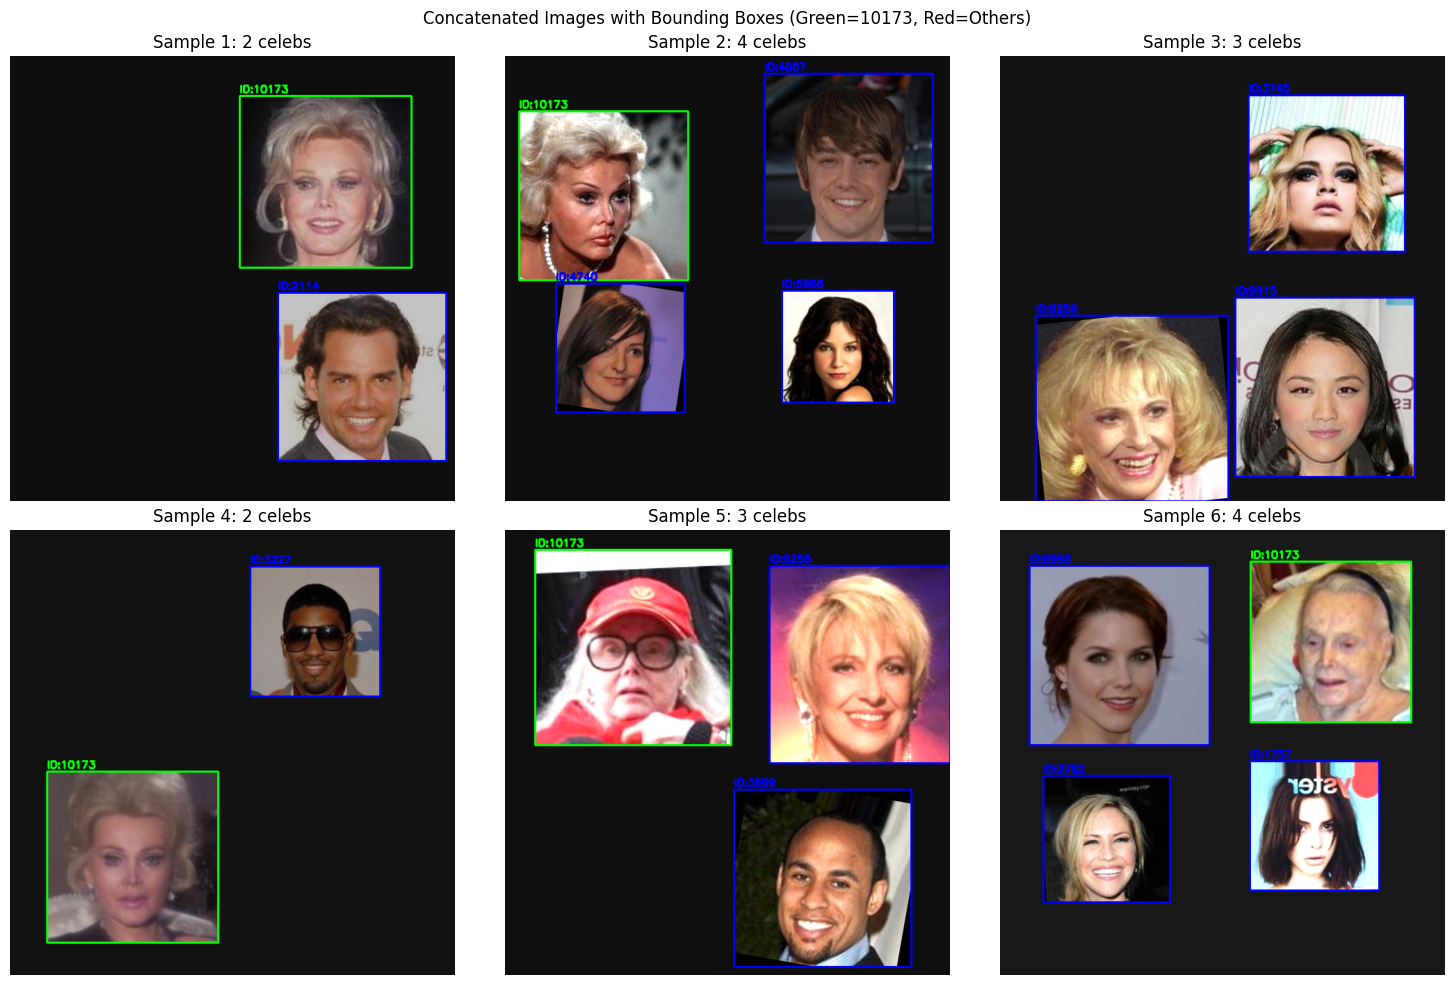

In [17]:
print("Creating sample concatenated images...")
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i in range(6):
    num_celebs = random.randint(2, min(4, len(celebrity_images)))
    img, annotations = create_concatenated_image(celebrity_images, num_celebs=num_celebs)
    
    # Draw bounding boxes
    img_with_boxes = img.copy()
    h, w = img_with_boxes.shape[:2]
    
    for ann in annotations:
        x1 = int((ann['cx'] - ann['width']/2) * w)
        y1 = int((ann['cy'] - ann['height']/2) * h)
        x2 = int((ann['cx'] + ann['width']/2) * w)
        y2 = int((ann['cy'] + ann['height']/2) * h)
        
        # Green for your celebrity, red for others
        color = (0, 255, 0) if ann['celeb_id'] == 10173 else (255, 0, 0)
        cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img_with_boxes, f"ID:{ann['celeb_id']}", 
                  (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
    
    img_rgb = cv2.cvtColor(img_with_boxes, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img_rgb)
    axes[i].set_title(f"Sample {i+1}: {len(annotations)} celebs")
    axes[i].axis('off')

plt.suptitle("Concatenated Images with Bounding Boxes (Green=10173, Red=Others)")
plt.tight_layout()
plt.show()

In [ ]:
def generate_dataset(dataset, celebrity_images, num_train=500, num_val=100, num_test=50):
    """Generate complete dataset with concatenated images"""
    
    print("\nGenerating concatenated images with augmentation...")
    
    splits = {
        'train': num_train,
        'val': num_val,
        'test': num_test
    }
    
    celeb_id_to_class = {celeb_id: idx for idx, celeb_id in enumerate(sorted(celebrity_images.keys()))}
    
    for split, num_images in splits.items():
        print(f"\nCreating {split} set: {num_images} images")
        
        for i in tqdm(range(num_images)):
            
            if split == 'train':
             
                num_celebs = random.randint(2, min(6, len(celebrity_images)))
            else:
                
                num_celebs = random.randint(3, min(5, len(celebrity_images)))
            
            # Create concatenated image
            img, annotations = create_concatenated_image(
                celebrity_images, 
                num_celebs=num_celebs,
                your_celeb_id=10173
            )
            
            # Save image
            img_filename = f"{split}_{i:04d}.jpg"
            img_path = dataset.data_dir / "images" / split / img_filename
            cv2.imwrite(str(img_path), img)
            
            # Save label (YOLO format)
            label_filename = f"{split}_{i:04d}.txt"
            label_path = dataset.data_dir / "labels" / split / label_filename
            
            with open(label_path, 'w') as f:
                for ann in annotations:
                   
                    class_idx = celeb_id_to_class[ann['celeb_id']]
                    f.write(f"{class_idx} {ann['cx']:.6f} {ann['cy']:.6f} "
                           f"{ann['width']:.6f} {ann['height']:.6f}\n")
            
        
            if i < 5 and split == 'train':
                sample_path = dataset.data_dir / "concatenated_samples" / f"{split}_{i}_sample.jpg"
                img_with_boxes = img.copy()
                h, w = img.shape[:2]
                for ann in annotations:
                    x1 = int((ann['cx'] - ann['width']/2) * w)
                    y1 = int((ann['cy'] - ann['height']/2) * h)
                    x2 = int((ann['cx'] + ann['width']/2) * w)
                    y2 = int((ann['cy'] + ann['height']/2) * h)
                    
                    color = (0, 255, 0) if ann['celeb_id'] == 10173 else (255, 0, 0)
                    cv2.rectangle(img_with_boxes, (x1, y1), (x2, y2), color, 2)
                    cv2.putText(img_with_boxes, f"ID:{ann['celeb_id']}", 
                              (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)
                cv2.imwrite(str(sample_path), img_with_boxes)
    
    print(f"\nDataset created successfully!")
    print(f"Total images: {num_train + num_val + num_test}")
    print(f"Celebrity 10173 included in dataset!")
    
    return celeb_id_to_class

celeb_id_to_class = generate_dataset(
    dataset, 
    celebrity_images,
    num_train=300,  
    num_val=50,
    num_test=30
)


Generating concatenated images with augmentation...

Creating train set: 300 images


100%|██████████| 300/300 [00:00<00:00, 557.25it/s]



Creating val set: 50 images


100%|██████████| 50/50 [00:00<00:00, 646.03it/s]



Creating test set: 30 images


100%|██████████| 30/30 [00:00<00:00, 545.29it/s]


Dataset created successfully!
Total images: 380
Celebrity 10173 included in dataset!


In [20]:
print(f"Celebrity ID to Class Mapping:")
for celeb_id, class_idx in celeb_id_to_class.items():
    if celeb_id == 10173:
        print(f"Celebrity {celeb_id} → Class {class_idx} (YOUR CELEBRITY)")
    else:
        print(f"Celebrity {celeb_id} → Class {class_idx}")

Celebrity ID to Class Mapping:
Celebrity 1757 → Class 0
Celebrity 2070 → Class 1
Celebrity 2114 → Class 2
Celebrity 2820 → Class 3
Celebrity 3227 → Class 4
Celebrity 3699 → Class 5
Celebrity 3745 → Class 6
Celebrity 3782 → Class 7
Celebrity 4126 → Class 8
Celebrity 4262 → Class 9
Celebrity 4740 → Class 10
Celebrity 4887 → Class 11
Celebrity 4978 → Class 12
Celebrity 6568 → Class 13
Celebrity 8968 → Class 14
Celebrity 9152 → Class 15
Celebrity 9256 → Class 16
Celebrity 9840 → Class 17
Celebrity 9915 → Class 18
Celebrity 10173 → Class 19 (YOUR CELEBRITY)


In [22]:
def create_yaml_config(dataset, celeb_id_to_class):
    """Create YAML configuration file for YOLOv8 training"""
    
    yaml_content = {
        'path': str(dataset.data_dir.absolute()),
        'train': 'images/train',
        'val': 'images/val',
        'test': 'images/test',
        
        # Number of classes
        'nc': len(celeb_id_to_class),
        
        # Class names (celebrity IDs)
        'names': {idx: f'celebrity_{celeb_id}' 
                 for celeb_id, idx in celeb_id_to_class.items()}
    }
    
    yaml_path = dataset.data_dir / 'dataset.yaml'
    with open(yaml_path, 'w') as f:
        yaml.dump(yaml_content, f, default_flow_style=False)
    
    print(f"Created dataset.yaml configuration file")
    print(f"Classes: {len(celeb_id_to_class)} celebrities")
    print(f"Celebrity 10173 is class: {celeb_id_to_class.get(10173, 'Not found')}")
    
    # Display yaml content
    print("\nYAML Configuration Preview:")
    print("-" * 40)
    with open(yaml_path, 'r') as f:
        content = f.read()
        print(content[:500] + "..." if len(content) > 500 else content)
    
    return yaml_path
yaml_path = create_yaml_config(dataset, celeb_id_to_class)

Created dataset.yaml configuration file
Classes: 20 celebrities
Celebrity 10173 is class: 19

YAML Configuration Preview:
----------------------------------------
names:
  0: celebrity_1757
  1: celebrity_2070
  2: celebrity_2114
  3: celebrity_2820
  4: celebrity_3227
  5: celebrity_3699
  6: celebrity_3745
  7: celebrity_3782
  8: celebrity_4126
  9: celebrity_4262
  10: celebrity_4740
  11: celebrity_4887
  12: celebrity_4978
  13: celebrity_6568
  14: celebrity_8968
  15: celebrity_9152
  16: celebrity_9256
  17: celebrity_9840
  18: celebrity_9915
  19: celebrity_10173
nc: 20
path: /Users/Deep Learning Core/celeba_detection
test: images/test
train: i...


In [23]:
print("Initializing YOLOv8 model...")


model = YOLO('yolov8n.pt') 

print(f" Model loaded: YOLOv8 nano")
print(f" Dataset config: {yaml_path}")
print(f" Device: {'CUDA' if torch.cuda.is_available() else 'CPU'}")

Initializing YOLOv8 model...
 Model loaded: YOLOv8 nano
 Dataset config: /Users/Deep Learning Core/celeba_detection/dataset.yaml
 Device: CPU


In [25]:
print("\nStarting YOLOv8 Training...")



results = model.train(
    data=str(yaml_path),
    epochs=30,  # Reduced for faster initial training
    imgsz=640,
    batch=8,  
    name='celebrity_detection',
    patience=10,
    save=True,
    device='cuda' if torch.cuda.is_available() else 'cpu',
    
    # Augmentation settings optimized for faces
    hsv_h=0.015,
    hsv_s=0.4,
    hsv_v=0.4,
    degrees=5.0,
    translate=0.1,
    scale=0.3,
    flipud=0.0,
    fliplr=0.5,
    mosaic=0.8,
    mixup=0.1,
    
    # Optimizer settings
    optimizer='AdamW',
    lr0=0.001,
    lrf=0.01,
    momentum=0.937,
    weight_decay=0.0005,
    warmup_epochs=3.0,
    
    # Loss weights
    box=7.5,
    cls=0.5,
    
    # Other
    verbose=True,
    plots=True
)

print("\nTraining completed!")
print(f"Results saved in: {results.save_dir if results else 'Check runs/detect/'}")


Starting YOLOv8 Training...
Ultralytics 8.3.205 🚀 Python-3.11.8 torch-2.5.1 CPU (Apple M3 Pro)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/Users/Deep Learning Core/celeba_detection/dataset.yaml, degrees=5.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=30, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.4, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.1, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=0.8, multi_scale=False, name=celebrity_detection2, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=

In [26]:
results_dir = Path('runs/detect/celebrity_detection')
if not results_dir.exists():
    # Try to find the latest run
    runs_dir = Path('runs/detect/')
    if runs_dir.exists():
        all_runs = sorted([d for d in runs_dir.iterdir() if d.is_dir() and 'celebrity' in d.name])
        if all_runs:
            results_dir = all_runs[-1]
            print(f"Found results in: {results_dir}")

if results_dir.exists():
    # Display training curves
    curves_path = results_dir / 'results.png'
    if curves_path.exists():
        from IPython.display import Image, display
        print("Training Curves:")
        display(Image(str(curves_path)))
    
    # Display confusion matrix if available
    confusion_path = results_dir / 'confusion_matrix.png'
    if confusion_path.exists():
        print("\nConfusion Matrix:")
        display(Image(str(confusion_path)))
    
    # Display validation batch predictions
    val_batch_path = results_dir / 'val_batch0_pred.jpg'
    if val_batch_path.exists():
        print("\n🔍 Validation Batch Predictions:")
        display(Image(str(val_batch_path)))
else:
    print("Results directory not found. Check 'runs/detect/' folder")


Testing the trained model...
Using current model (best weights not found)

image 1/1 /Users/Deep Learning Core/celeba_detection/images/test/test_0026.jpg: 640x640 1 celebrity_2070, 1 celebrity_4126, 1 celebrity_4262, 1 celebrity_4887, 1 celebrity_6568, 1 celebrity_10173, 65.7ms
Speed: 1.3ms preprocess, 65.7ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

Image 1 detections:
is here Celebrity 10173: 97.66% confidence
   Celebrity 2070: 90.12% confidence
   Celebrity 4262: 78.88% confidence
   Celebrity 4126: 57.45% confidence
   Celebrity 4887: 38.54% confidence
   Celebrity 6568: 34.57% confidence

image 1/1 /Users/Deep Learning Core/celeba_detection/images/test/test_0027.jpg: 640x640 1 celebrity_1757, 1 celebrity_3227, 1 celebrity_3699, 1 celebrity_10173, 61.3ms
Speed: 0.8ms preprocess, 61.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

Image 2 detections:
   Celebrity 3699: 99.29% confidence
is here Celebrity 10173: 98.99% confidence
   Cele

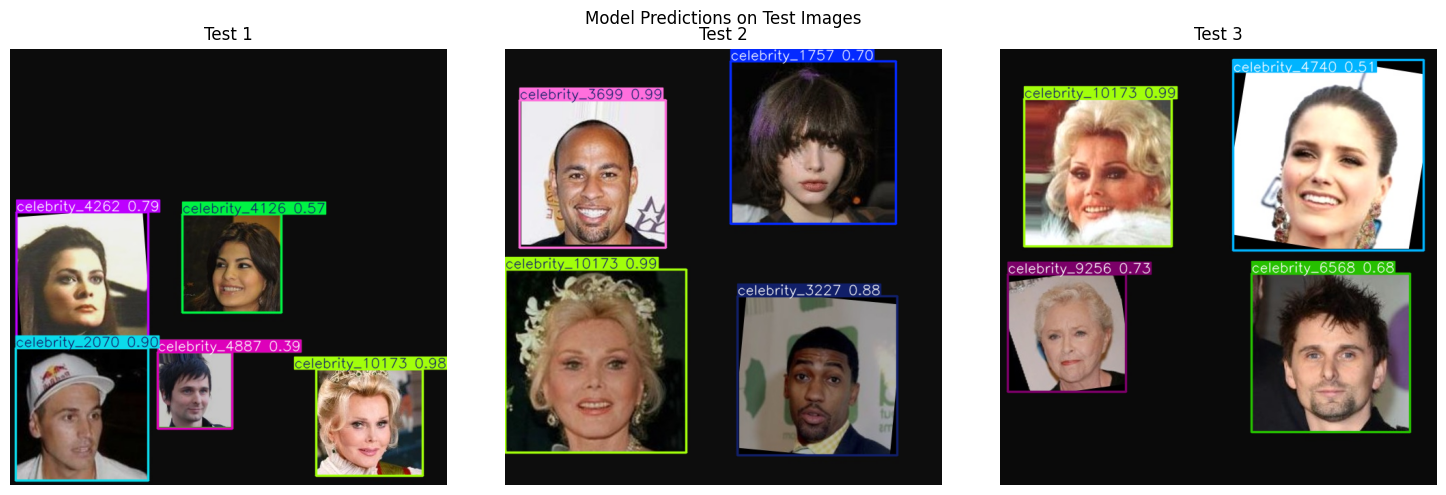

In [27]:
print("\nTesting the trained model...")

# Load the best model
best_model_path = results_dir / 'weights' / 'best.pt' if results_dir.exists() else None

if best_model_path and best_model_path.exists():
    model = YOLO(best_model_path)
    print(f"Loaded best model from: {best_model_path}")
else:
    print("Using current model (best weights not found)")

# Test on sample images
test_images = list((dataset.data_dir / "images" / "test").glob("*.jpg"))[:5]

if test_images:
    fig, axes = plt.subplots(1, min(3, len(test_images)), figsize=(15, 5))
    if len(test_images) == 1:
        axes = [axes]
    
    for idx, test_img_path in enumerate(test_images[:3]):
        # Run inference
        results = model(test_img_path, conf=0.25, iou=0.45)
        
        # Plot results
        annotated = results[0].plot()
        annotated_rgb = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
        
        axes[idx].imshow(annotated_rgb)
        axes[idx].set_title(f"Test {idx+1}")
        axes[idx].axis('off')
        
        # Print detections
        if results[0].boxes is not None:
            print(f"\nImage {idx+1} detections:")
            for box in results[0].boxes:
                cls = int(box.cls)
                conf = float(box.conf)
                celeb_id = [k for k, v in celeb_id_to_class.items() if v == cls][0]
                star = "is here" if celeb_id == 10173 else "  "
                print(f"{star} Celebrity {celeb_id}: {conf:.2%} confidence")
    
    plt.suptitle("Model Predictions on Test Images")
    plt.tight_layout()
    plt.show()
else:
    print("⚠️ No test images found")

In [32]:
print("\nEvaluating model performance...")

# Validate on test set
if yaml_path.exists():
    val_results = model.val(data=str(yaml_path), split='test')
    
    print("\nPerformance Metrics:")
    print(f"  mAP@0.5: {val_results.box.map50:.3f}")
    print(f"  mAP@0.5:0.95: {val_results.box.map:.3f}")
    print(f"  Precision: {val_results.box.mp:.3f}")
    print(f"  Recall: {val_results.box.mr:.3f}")
    
    #my celeb id 10173
    if hasattr(val_results.box, 'class_result'):
        your_class = celeb_id_to_class.get(10173)
        if your_class is not None:
            print(f"\nCelebrity 10173 (Class {your_class}) Performance:")


Evaluating model performance...
Ultralytics 8.3.205 🚀 Python-3.11.8 torch-2.5.1 CPU (Apple M3 Pro)
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 240.2±64.5 MB/s, size: 55.9 KB)
val: Scanning /Users/Deep Learning Core/celeba_detection/labels/test.cache... 30 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 30/30 107.5Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 2/2 0.5it/s 3.7s9.0s
                   all         30        119      0.773       0.82       0.88       0.88
        celebrity_1757          6          6      0.765        0.5      0.859      0.859
        celebrity_2070          2          2      0.712          1      0.995      0.995
        celebrity_2114          5          5      0.807       0.84      0.895      0.895
        celebrity_2820          6          6      0.937      0.833      0.915      0.915
        celebrity_3227         12         12      0.973          1      0.995      0.995
